In [83]:
print(1)

1


In [1]:
import numpy as np
from math import isnan
import threading as trd
import math
import random as rnd
import copy
    

#def estimate_gaussian(data):
 #   return np.mean(data),np.cov(data)
    
    
def info_gain(data,cov,data_l,cov_l,data_r,cov_r):
    
    a=np.linalg.det(cov)
    if(isnan(a)==True):
        a=0.000000000000000000001
    a=np.log(abs(a))
    
    
    b=np.linalg.det(cov_l)
    if np.isnan(b)==True:
        b=0.000000000000000000001
    #print(data_l.shape[1])
    b=(data_l.shape[0]/data.shape[0]) * np.log(abs(b))
    
    
    c=np.linalg.det(cov_r)
    if np.isnan(c)==True:
        c=0.000000000000000000001
    c=(data_r.shape[0]/data.shape[0]) * np.log(abs(c))
    
    return a-b-c
    
def split_data_axis(data,split,direction):
#    print('hi')
    left_data=np.array([[0,0]])
    right_data=np.array([[0,0]])
    for d in range(data.shape[0]):
        if data[d][direction]<=split:
            left_data=np.append(left_data,np.reshape(data[d],(1,data[d].shape[0])),axis=0)
        else:
            right_data=np.append(right_data,np.reshape(data[d],(1,data[d].shape[0])),axis=0)
            
   # print(left_data)
    left_data=np.delete(left_data,0,axis=0)
    right_data=np.delete(right_data,0,axis=0)
    return(left_data,right_data)
    
def split_data_lin(data,start,direction):
    left_data=np.array([[0,0]])
    right_data=np.array([[0,0]])
    i=0
    for d in range(data.shape[0]):
        #print(np.cross(direction-start,start-d))
        #(b−a)×(c−a)
        #if i<=5:
         #   print(d,start,(start+direction)-start,d-start)
          #  i+=1
        if np.cross((start+direction)-start,data[d]-start)<0:
            left_data=np.append(left_data,np.reshape(data[d],(1,data[d].shape[0])),axis=0)
        else:
            right_data=np.append(right_data,np.reshape(data[d],(1,data[d].shape[0])),axis=0)
            
   # print(left_data)
    left_data=np.delete(left_data,0,axis=0)
    right_data=np.delete(right_data,0,axis=0)
    return(left_data,right_data)

class RandomDensityTree:

    def __init__(self,max_depth=10,num_splits=50,min_infogain=2,rand=True,splittype='axis'):
       # print(data)
        self.rand=rand
        self.splittype=splittype
        self.max_depth = max_depth
        #self.root=data
        tree=[]
        for i in range(30):
            tree.append(0)
        self.tree=tree
        self.min_infogain=min_infogain
        self.num_splits=num_splits
        
    def fit(self,data,axis=0):
        if(axis==1):
            data=np.transpose(data)
        self.size=data.shape[0]
        self.root=data
        self.mean = np.mean(data,axis=0)
        self.cov=np.cov(np.transpose(data))
        self.rootnode=Node(data,self.cov,[],self.tree,num_splits=self.num_splits,min_infogain=self.min_infogain,max_depth=self.max_depth,pointer=0,rand=self.rand,splittype=self.splittype)
        self.tree[0]=self.rootnode

    def predict(self,points):
        new=[]
        for p in points:
            new.append(self.rootnode.predict(p))
        new=np.array(new)
        return new
    
    def max_prob():
        leafs=self.leaf_nodes()
        probs=[]
        for l in leafs:
            probs.append(np.det(cov))*math.sqrt(2*math.pi)
        return max(probs)

    def get_means(self):
        means=[]
        self.rootnode.get_means(means)
        return means
    
    def get_split_info(self):
        histories=[]
        self.rootnode.get_split_info(means)
        return histories
   # def maxinfo(self):
    #    np.cov(np.transpose(left_data))
    def leaf_nodes(self):
        leafs=[]
        self.rootnode.leaf_nodes(leafs)
        return np.array(leafs)
    
class Node:
    
    def __init__(self,data,cov,history,tree,num_splits,min_infogain,max_depth,pointer,rand=True,splittype='axis'):
     #   print(data.shape)
        #self.min_infgain=min_infgain
        self.maxdepth=max_depth
        self.min_infogain=min_infogain
        self.pointer=pointer
        self.size=data.shape[0]
        self.tree=tree
        self.num_splits=num_splits
    #    tree[pointer]={''}
        self.split=float('nan')
        self.split_dim=float('nan')
        self.history=copy.deepcopy(history)
        self.splittype=splittype
        self.root=data
        self.mean=np.mean(data,axis=0)
        self.cov=cov
        self.isLeaf=False
        self.left_child=float('nan')
        self.right_child=float('nan')
        if(max_depth==0 or data.shape[0]==1):
            self.isLeaf=True
           
        else:
            
            rnd_splits=[]
            if(rand==True):
                for dim in range(int(num_splits)):
                    direction=rnd.choice([0,1])

                    rnd_split=rnd.uniform(min(data[:,direction]),max(data[:,direction]))
                

                    rnd_splits.append({'split':rnd_split,'direction':direction})

            else:
                rnd_splits=np.concatenate([np.linspace(min(data[:,0]),max(data[:,0])),np.linspace(min(data[:,1]),max(data[:,1]))],axis=0)
           
        
            if(self.splittype=='linear'):
                rnd_splits=[]
                for n in range(num_splits):
                    start=np.array([rnd.uniform(min(data[:,0]),max(data[:,0])),rnd.uniform(min(data[:,1]),max(data[:,1]))])
                    dir1=rnd.uniform(0,1)
                    direction=np.array([dir1,1-dir1])
                    direction[0]= direction[0]*rnd.choice([-1,1])
                    direction[1]= direction[1]*rnd.choice([-1,1])
                    rnd_splits.append({'split': start,'direction': direction})
                    
            
            left_datas=[]
            info_gains=np.zeros(num_splits)
            right_datas=[]

            covs_left=[]
            covs_right=[]

            for s in range(num_splits):#or the number of random splits
                
                
                if (self.splittype=='linear'):
                    left_data,right_data=split_data_lin(data,rnd_splits[s]['split'],rnd_splits[s]['direction'])
                else:
                    left_data,right_data=split_data_axis(data,rnd_splits[s]['split'],rnd_splits[s]['direction'])
                if(left_data.shape[0]>2 and right_data.shape[0]>2):
          #          print('split ' +str(rnd_splits[s]['split'])+'  direction: '+str(rnd_splits[s]['direction']))
                   # left_data=[] #data left of the split
                   # right_data=[] #data right of the split
                    #for a in data:
                     #   if a <= splits[d]:
                      #      if(max_depth=left_data.append(a)
                       # else:
                        #    right_data.append(a)
                  #  right_data

                    right_datas.append(right_data)
                    left_datas.append(left_data)

                    cov_l=np.cov(np.transpose(left_data))
                    cov_r=np.cov(np.transpose(right_data))

                    covs_left.append(cov_l)
                    covs_right.append(cov_r)
                 #   print(left_data)
                    info_gains[s]=(info_gain(data,self.cov,left_data,cov_l,right_data,cov_r)) #entropies of left and right data)
                else:
                    right_datas.append(float('nan'))
                    left_datas.append(float('nan'))
                    covs_left.append(float('nan'))
                    covs_right.append(float('nan'))
                    #information gain if this split is used
            if len(info_gains)==0:
                self.isLeaf=True
                   
            else:

                best=np.argmax(info_gains)
                #print('best infogain: '+str(info_gains[best]))
            #    print(min_infogain)
                if info_gains[best] >= min_infogain:
                    
                    self.split=rnd_splits[best]['split']   #best split
                    self.split_dim=rnd_splits[best]['direction'] 
                    self.history.append(rnd_splits[best])
                    if(2*pointer+2>=len(tree)):
                        for i in range((2*pointer+2)-len(tree)+1):
                            tree.append(0)
                   # print(left_datas[best].shape)
                    #print(right_datas[best].shape)
              #      print(self.history)
                    #print((left_datas[best],covs_left[best],history,tree,self.num_splits,self.min_infogain,self.maxdepth-1,2*pointer+1))
                    self.history[len(self.history)-1]['child']='left'
               #     print(('history',self.history))
                    leftnode=Node(left_datas[best],covs_left[best],self.history,tree,self.num_splits,self.min_infogain,self.maxdepth-1,2*pointer+1,rand=rand,splittype=self.splittype)
                    tree[2*pointer+1]=leftnode
                    self.left_child=leftnode
            
                   # print(len(right_datas[best],covs_right[best],history,self.num_splits,self.min_infogain,s2))
                    
                    self.history[len(self.history)-1]['child']='right'
                    rightnode=Node(right_datas[best],covs_right[best],self.history,tree,self.num_splits,self.min_infogain,self.maxdepth-1,2*pointer+2,rand=rand,splittype=self.splittype)
                    tree[2*pointer+2]=rightnode
                    self.right_child=rightnode
                    
                else:
         
                    self.isLeaf=True
       # print((self.isLeaf,self.left_child))
    def predict(self,point):
        if self.isLeaf==True:
            return self.pointer
        else:
            if(self.splittype=='axis'):
                if point[self.split_dim]<=self.split:
                    return self.left_child.predict(point)
                else:
                    return self.right_child.predict(point)
            else:
                #(b−a)×(c−a)
                 if np.cross((self.split+self.split_dim)-self.split,point-self.split)<0:
                    return self.left_child.predict(point)
                 else:
                    return self.right_child.predict(point)
                
    '''         
     def get_split_info(self,histories):
        if(self.isLeaf==True):
            return self.history
            print('whoa')
        else:
            return [{'split':self.split,'split_dim':self.split_dim,},{'left_child':self.left_child.get_results()},{'right_child':self.right_child.get_results()}]
    '''
    def get_split_info(self,histories):
        if(self.isLeaf==True):
            histories.append(self.history)
        else:
            self.left_child.get_histories(histories)
            self.right_child.get_histories(histories)

    def get_means(self,means):
        if(self.isLeaf==True):
            means.append(self.mean)
        else:
            self.left_child.get_means(means)
            self.right_child.get_means(means)
            
    def maxprob():
        return 1
    
    def leaf_nodes(self,leafs):
      #  if self.left_child.isLeaf == True:
       #     leafs.append(self.left_child.pointer)
        if(self.isLeaf==True):
            leafs.append(self.pointer)
        else:
            self.left_child.leaf_nodes(leafs)
      #  if self.right_child.isLeaf == True:
       #     leafs.append(self.right_child)
        #else:
            self.right_child.leaf_nodes(leafs)
        
    def isnan(self):
        return False
    
def partition_function(tree, x):
    # generate a lot of samples in the bounds of the data and the size of the bounded shape
    samples, b_size = generate_monte_carlo_sample(x)
    # add gaussian probability dimension for those samples
    g_probs_samples = np.random.random(len(samples))*tree.max_prob
    b_size = b_size*tree.max_prob
    # predict the target leb af nodes for all samples
    leaf_node_ids = tree.predict(samples)
    # compute the distribution integral over each leaf node
    g_ints = np.zeros((len(tree.leaf_nodes),))
    for ln_id in range(len(tree.leaf_nodes)):
        leaf_node = tree.leaf_nodes[ln_id]
        mean_vec = leaf_node.mean
        cov_mat = leaf_node.cov
        mnd = stats.multivariate_normal(mean_vec, cov_mat)
        sample_id_mask = leaf_node_ids==ln_id
        g_probs = mnd(samples[sample_id_mask])
        g_cnt = np.sum(g_probs_samples<=g_probs)
        g_ints[ln_id] = g_cnt/len(samples)*b_size
    


def generate_monte_carlo_sample(X, num_samples=1000000):
    """
    Generate more sample points
    """
    samples = np.random.rand(num_samples,len(X[0]))
    d_mins = np.min(X,axis=0)
    d_maxs = np.max(X,axis=0)
    samples = np.add(np.multiply(samples,d_maxs-d_mins),d_mins)
    b_size = np.prod(d_maxs-d_mins)
    return samples, b_size    
'''
class RandomDensityForest:
    def _init(self,max_length=10,num_trees=10):
        self.max_length=max_length
        self.num_trees=num_trees
        
    def train_and_stuff(data):
        #lauch DensityTrees
        #train on data
        #return results
        #use partition function
        #combine them into final result
    
    I= entropy - sum
theta= max(I)    
'''

'\nclass RandomDensityForest:\n    def _init(self,max_length=10,num_trees=10):\n        self.max_length=max_length\n        self.num_trees=num_trees\n        \n    def train_and_stuff(data):\n        #lauch DensityTrees\n        #train on data\n        #return results\n        #use partition function\n        #combine them into final result\n    \n    I= entropy - sum\ntheta= max(I)    \n'

In [ ]:
#    for h in tree[d].history:
 #       #plotsplits(h,0)
   #     if h['direction']==0:
  #          ax.plot([h['split'],h['split']],vert,color='k')
    #        if(h['child']=='left'):
     #           hor=[hor[0],h['split']]
      #      else:
      #          hor=[h['split'],hor[1]]
      #  else:
       #     ax.plot(hor,[h['split'],h['split']],color='k')
        #    if(h['child']=='left'):
         #       vert=[vert[0],h['split']]
          #  else:
           #     vert=[h['split'],vert[1]]

In [2]:
from matplotlib.patches import Ellipse

def plotsplits(h,s,hor=[0,6],vert=[0,6]):
   
        plotsplits(h,s+1,hor,vert) 


def plotaxis(data,DensityTree,xlim=[0,6],ylim=[0,6],title='test',showcov=True):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_ylim(ylim[0],ylim[1])
    ax.set_xlim(xlim[0],xlim[1])

    nodes=DensityTree.leaf_nodes()
    tree=DensityTree.tree
    ax.plot(data[:,0],data[:,1], "o")
    
    for d in nodes:
#print(tree[d].split)
 #       print(tree[d].history)
        vert=xlim
        hor=ylim
        for h in tree[d].history:
            #plotsplits(h,0)
            if h['direction']==0:
                ax.plot([h['split'],h['split']],vert,color='k')
                if(h['child']=='left'):
                    hor=[hor[0],h['split']]
                else:
                    hor=[h['split'],hor[1]]
            else:
                ax.plot(hor,[h['split'],h['split']],color='k')
                if(h['child']=='left'):
                    vert=[vert[0],h['split']]
                else:
                    vert=[h['split'],vert[1]]
        if(showcov==True):
            vec1=np.array([0,1])
            eigvals,eigvecs=np.linalg.eig(tree[d].cov)
            e=Ellipse(xy=tree[d].mean, width=math.sqrt(eigvals[0])*3, height=math.sqrt(eigvals[1])*3, angle=np.arccos(np.dot(eigvecs[0],vec1)/(np.linalg.norm(vec1)*np.linalg.norm(eigvecs[0]))),alpha=0.5)
            ax.add_artist(e)

            plt.plot(tree[d].mean[0],tree[d].mean[1],'o',color='r')
        #plt.savefig('example.png')
     #   lines=d.history
      #  if lines['direction']==0:
       #     plot
       # plt.savefig('results')
    plt.show()
    

   # plt.savefig('results')
    
def plotlin(data,DensityTree,xlim=[0,6],ylim=[0,6],title='test',showcov=True):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_ylim(ylim[0],ylim[1])
    ax.set_xlim(xlim[0],xlim[1])

    nodes=DensityTree.leaf_nodes()
    tree=DensityTree.tree
    ax.plot(data[:,0],data[:,1], "o")
    
    for d in nodes:

        vert=xlim
        hor=ylim
        for h in tree[d].history:
          #  multiplier1 = np.cross((h['split'] − [0,0]), h['direction']) / ([0,6] × h['direction'])
          #  t = (q − p) × s / (r × s)
            ax.plot([(h['split']+h['direction']*10)[0],(h['split']+h['direction']*-10)[0]],[(h['split']+h['direction']*10)[1],(h['split']+h['direction']*-10)[1]],color='k')
            ax.plot(h['split'][0],h['split'][1],"s",color='g')
        if(showcov==True):
            vec1=np.array([0,1])
            eigvals,eigvecs=np.linalg.eig(tree[d].cov)
            e=Ellipse(xy=tree[d].mean, width=math.sqrt(eigvals[0])*3, height=math.sqrt(eigvals[1])*3, angle=np.arccos(np.dot(eigvecs[0],vec1)/(np.linalg.norm(vec1)*np.linalg.norm(eigvecs[0]))),alpha=0.5)
            ax.add_artist(e)

            plt.plot(tree[d].mean[0],tree[d].mean[1],'o',color='r')

    plt.show()
#plotaxis(data,DensityTree,xlim=[0,6],ylim=[0,6])

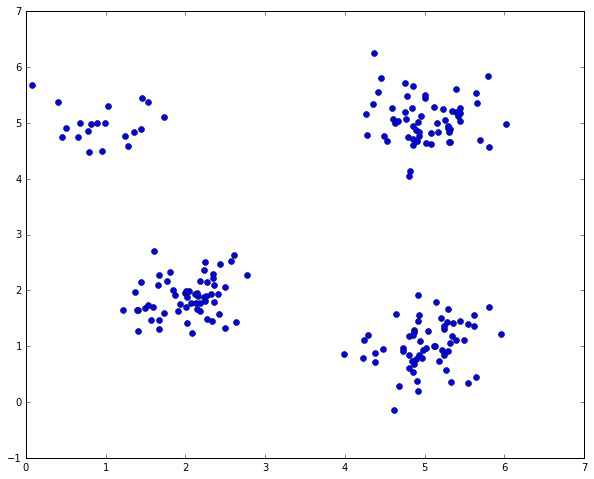

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
#

data = np.zeros([200,2])
for i in range(60):
    data[i]=np.random.normal([2,2],0.4)
   # data[i][0]=np.random.normal(2,0.5)[0]
    #data[i][1]=np.random.normal(2)[1]
for i in range(60):
    data[60+i]=np.random.normal([5,5],0.4)
    #data[30+i][1]=np.random.normal(5,0.5) 
for i in range(60):
    data[120+i]=np.random.normal([5,1],0.4)
   
for i in range(20):
    data[180+i]=np.random.normal([1,5],0.4)
plt.figure(figsize=(10,8))
plt.plot(data[:,0],data[:,1], "o")

plt.show()

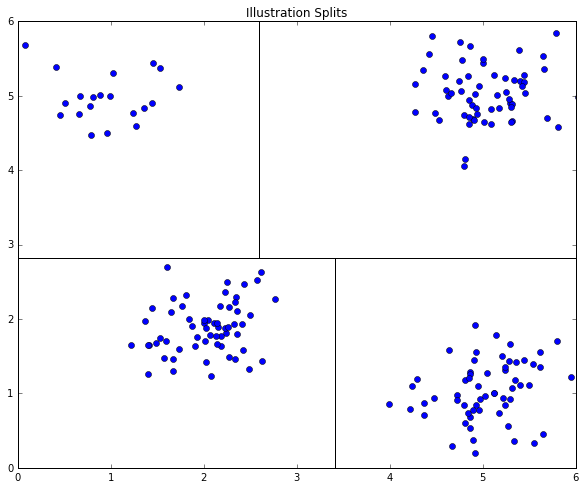

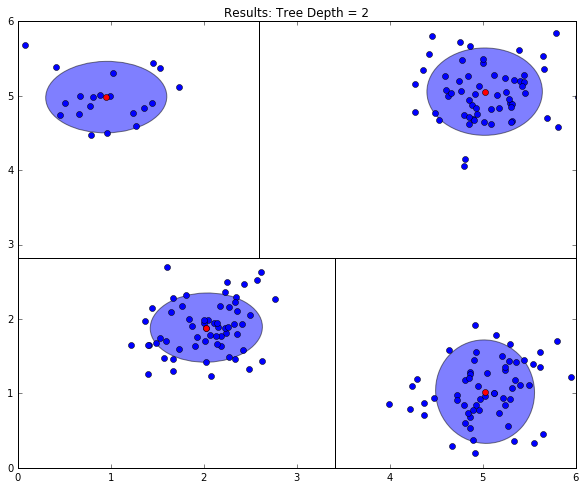

In [4]:
DensityTree1=RandomDensityTree(max_depth=2,min_infogain=0.2,num_splits=50)
DensityTree1.fit(data)

plotaxis(data,DensityTree1,xlim=[0,6],ylim=[0,6],showcov=False,title='Illustration Splits')
plotaxis(data,DensityTree1,xlim=[0,6],ylim=[0,6],title='Results: Tree Depth = 2')

#DensityTree2=RandomDensityTree(max_depth=2,splittype='linear',min_infogain=0.2,num_splits=400)
#DensityTree2.fit(data)

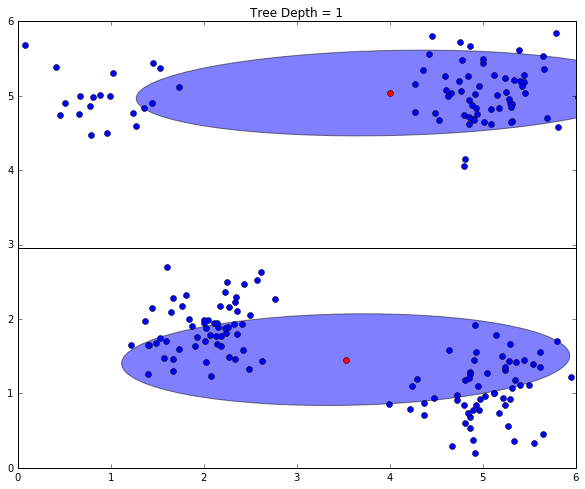

In [5]:
DensityTree2=RandomDensityTree(max_depth=1,min_infogain=0.2,num_splits=50)
DensityTree2.fit(data)
plotaxis(data,DensityTree2,xlim=[0,6],ylim=[0,6],title='Tree Depth = 1')


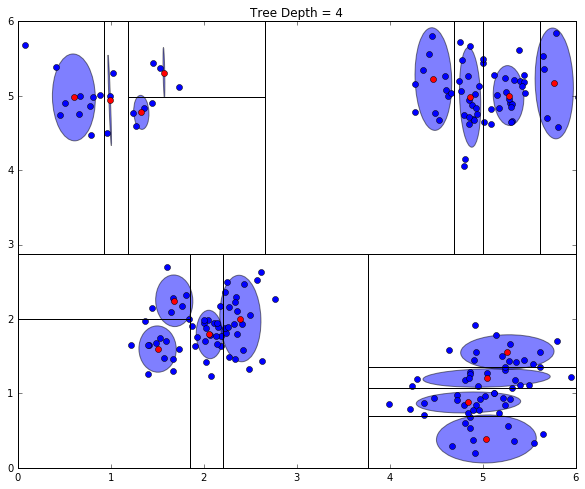

In [6]:
DensityTree3=RandomDensityTree(max_depth=4,min_infogain=0.001,num_splits=50)
DensityTree3.fit(data)
plotaxis(data,DensityTree3,xlim=[0,6],ylim=[0,6],title='Tree Depth = 4')




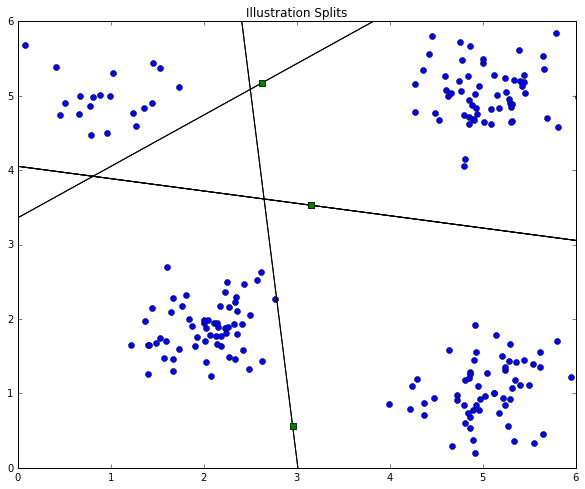

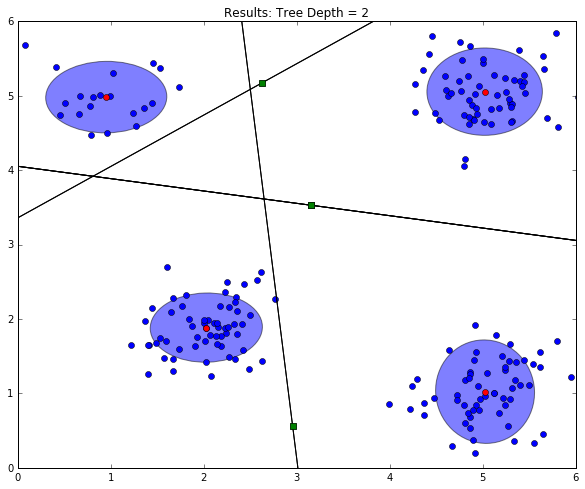

In [9]:
DensityTree5=RandomDensityTree(max_depth=2,min_infogain=0.2,num_splits=50,splittype='linear')
DensityTree5.fit(data)

plotlin(data,DensityTree5,xlim=[0,6],ylim=[0,6],showcov=False,title='Illustration Splits')
plotlin(data,DensityTree5,xlim=[0,6],ylim=[0,6],title='Results: Tree Depth = 2')